## Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from collections import OrderedDict
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


<hr>

## Parameters

In [65]:
parameters = {
    'batch_size': 64,
    'lr': 1e-4,
    'epochs': 50,
    'T': 30
}

<hr>

## Loading Files

In [3]:
X = np.load('/kaggle/input/active-learning-subset/tar_image_subset.npy')
y = np.load('/kaggle/input/active-learning-subset/label_target_subset.npy')

print(X.shape, y.shape)

(20000, 6, 28) (20000,)


In [4]:
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_val.shape)

(16000, 6, 28) (4000, 6, 28)


In [5]:
# Checking the label distribution of the train set
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
total = counts_train.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels_train, counts_train):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         7265      45.41%
1         2082      13.01%
2         6653      41.58%

Total samples: 16000


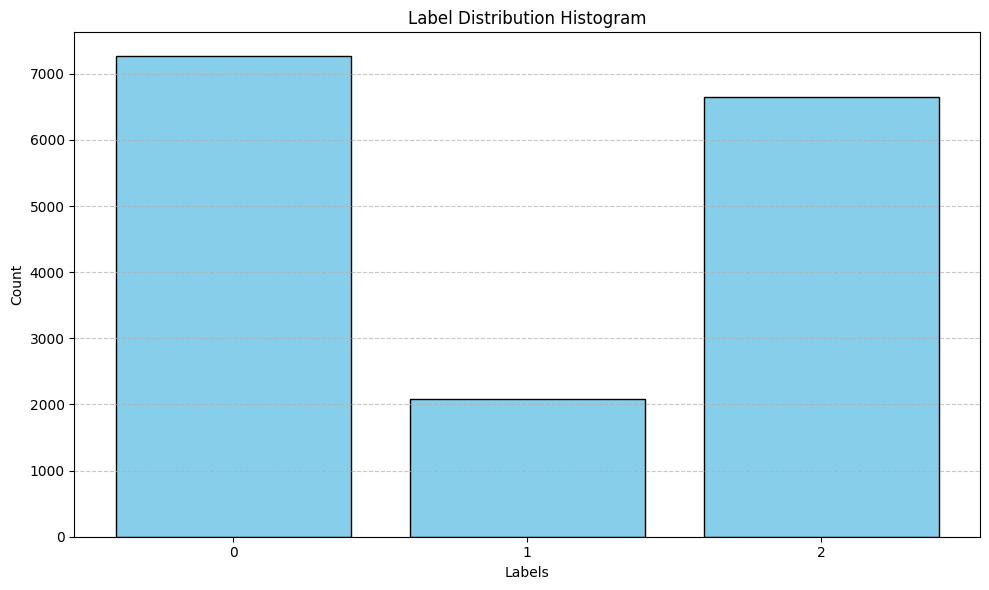

In [6]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels_train.astype(str), counts_train, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Checking the label distribution of the val set
unique_labels_val, counts_val = np.unique(y_val, return_counts=True)
total = counts_val.sum()

print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels_val, counts_val):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

Label     Count     Percentage
------------------------------
0         1816      45.40%
1         521       13.03%
2         1663      41.58%

Total samples: 4000


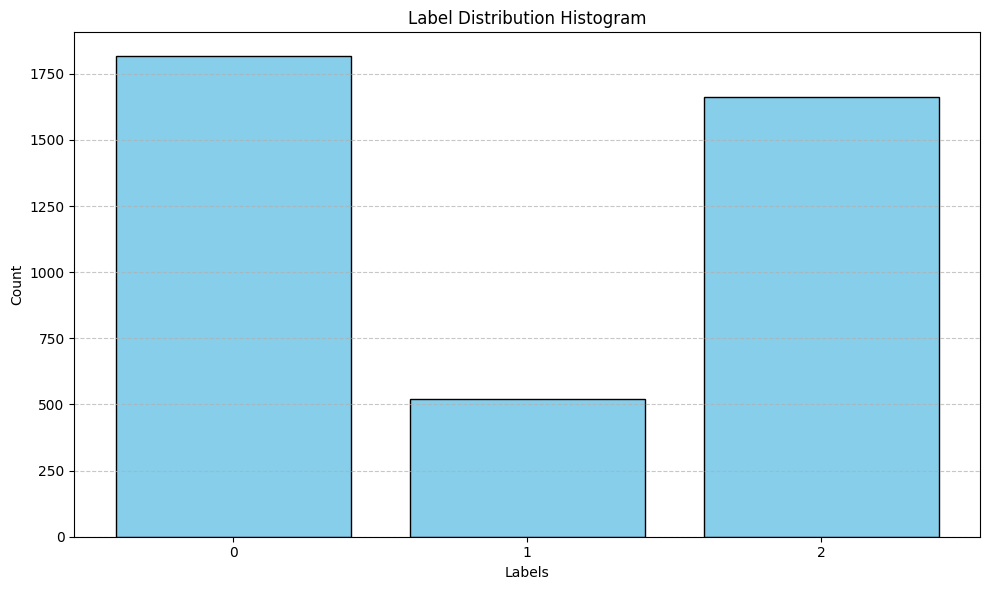

In [8]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels_val.astype(str), counts_val, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Label Distribution Histogram")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<hr>

## Dataset Class

In [9]:
class SimpleDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images.astype(np.float32)
        self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])  # shape: (6, 28)
        y = torch.tensor(self.labels[idx])
        return {"x": x, "y": y}

In [10]:
# For evaluation
val_dataset = SimpleDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=False)

<hr>

## Model

In [45]:
################ CNN Backbone
def conv_block(in_channels: int, out_channels: int, dropout_p=0.5) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )
 
 
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.5):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, 3)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [66]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

# Initialize and load models
backbone = cnn_dropout()
backbone.to(device)

fc = FC_dropout(1024)
fc.to(device)

backbone.load_state_dict(backbone_state)
fc.load_state_dict(fc_state)

<All keys matched successfully>

In [47]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

<hr>

## Evaluation Function

In [67]:
def mc_dropout_eval(backbone, fc, dataloader, T=20):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    all_uncertainties = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            all_labels.append(y.cpu())

            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

            # Entropy: -sum(p * log(p))
            entropy = -(mc_mean * torch.log(mc_mean + 1e-10)).sum(dim=1)  # (B,)

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())
            all_uncertainties.append(entropy.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_uncertainties = torch.cat(all_uncertainties).numpy()  # Shape: (N,)

    acc = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average="macro")
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    avg_entropy = np.mean(all_uncertainties)

    return acc, f1_macro, f1_per_class, avg_entropy

<hr>

## Query Sampler (Aquisition Functions)

In [49]:
# # Initialize pools
# labeled_pool = set()
# unlabeled_pool = set(range(len(X)))  # {0, 1, ..., 19999}

# # ============= Predictive Entropy ============= 
# def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, sim=20):
#     model_backbone.eval()
#     model_fc.eval()
#     enable_dropout(model_backbone)
#     enable_dropout(model_fc)

#     indices = list(unlabeled_pool)
#     X_pool = X[indices]
#     mc_probs = []

#     with torch.no_grad():
#         for _ in range(sim):
#             logits = []
#             for i in range(0, len(X_pool), 32):
#                 x_batch = torch.tensor(X_pool[i:i+32]).float().to(device)
#                 feats = model_backbone(x_batch)
#                 out = model_fc(feats)
#                 logits.append(F.softmax(out, dim=1).cpu())
#             probs = torch.cat(logits, dim=0)
#             mc_probs.append(probs)

#     mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
#     avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
#     entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

#     topk = torch.topk(entropy, k=k).indices
#     return [indices[i.item()] for i in topk]

<hr>

## Training Loop

In [68]:
all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

num_classes = 3  # e.g., 5 for 5 classes

# Flatten labels and count occurrences
flattened = all_labels.flatten()
flattened = flattened[flattened >= 0]
class_counts = np.bincount(flattened, minlength=num_classes)
total_pixels = class_counts.sum()

# Inverse frequency (optionally normalize)
class_weights = total_pixels / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights = torch.log(1 + class_weights)

print(class_weights)

tensor([0.5505, 1.2702, 0.5887], device='cuda:0')


In [69]:
def train_model(backbone, fc, train_loader, val_loader, parameters, T=20):
    # Optimizer
    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fc.parameters()), lr=parameters['lr'])

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(parameters['epochs']):
        backbone.train()
        fc.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{parameters['epochs']} [Training]"):
            x = batch['x'].to(device)
            y = batch['y'].to(device)

            optimizer.zero_grad()
            features = backbone(x)
            logits = fc(features)
            loss = F.cross_entropy(logits, y, weight=class_weights)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        # Validation with MC Dropout
        val_acc, val_avg_f1s, _, val_avg_entropy = mc_dropout_eval(backbone, fc, val_loader, T)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{parameters['epochs']} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    return train_losses, train_accuracies, val_accuracies, val_avg_f1s, val_avg_entropy

In [70]:
subset_sizes = list(range(1000, 8000+1, 1000))  # [1000, 2000, ..., 8000]

elbow_history = {
    "subset_size": [],
    "train_accuracy": [],
    "train_loss": [],
    "val_accuracy": [],
    "val_avg_f1": [],
    "val_uncertainty": []
}

for size in subset_sizes:
    print(f"\nTraining with {size} samples...")
    
    subset_indices = np.arange(size)
    X_subset = X_train[subset_indices]
    y_subset = y_train[subset_indices]

    # Create dataset & dataloader with WeightedRandomSampler
    dataset = SimpleDataset(X_subset, y_subset)

    class_counts = np.bincount(y_subset)
    weights = 1. / class_counts
    sample_weights = weights[y_subset]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = DataLoader(dataset, batch_size=parameters['batch_size'], sampler=sampler, shuffle=False)

    # Fresh model for each subset
    backbone_model = cnn_dropout().to(device)
    fc_model = FC_dropout(1024).to(device)
    backbone_model.load_state_dict(backbone_state)
    fc_model.load_state_dict(fc_state)

    # Train
    train_losses, train_accs, val_accs, val_avg_f1s, val_entropy = train_model(backbone_model, fc_model, loader, val_dataloader, parameters, T=10)
    
    # Save final epoch stats
    elbow_history["subset_size"].append(size)
    elbow_history["train_loss"].append(train_losses[-1])
    elbow_history["train_accuracy"].append(train_accs[-1])
    elbow_history["val_accuracy"].append(val_accs[-1])
    elbow_history["val_avg_f1"].append(val_avg_f1s)
    elbow_history["val_uncertainty"].append(val_entropy)


Training with 1000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 1/50 | Train Loss: 2.1659 | Train Acc: 40.50% | Val Acc: 44.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 2/50 | Train Loss: 1.7025 | Train Acc: 48.10% | Val Acc: 27.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 3/50 | Train Loss: 1.4737 | Train Acc: 55.70% | Val Acc: 49.68%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 4/50 | Train Loss: 1.2902 | Train Acc: 57.70% | Val Acc: 63.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 5/50 | Train Loss: 1.2063 | Train Acc: 60.10% | Val Acc: 60.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 6/50 | Train Loss: 1.0631 | Train Acc: 63.60% | Val Acc: 64.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 7/50 | Train Loss: 1.0375 | Train Acc: 65.90% | Val Acc: 68.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 8/50 | Train Loss: 0.9591 | Train Acc: 65.50% | Val Acc: 72.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 9/50 | Train Loss: 0.8645 | Train Acc: 67.40% | Val Acc: 70.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 10/50 | Train Loss: 0.9285 | Train Acc: 66.10% | Val Acc: 68.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 11/50 | Train Loss: 0.8107 | Train Acc: 69.30% | Val Acc: 73.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 12/50 | Train Loss: 0.7511 | Train Acc: 69.60% | Val Acc: 70.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 13/50 | Train Loss: 0.7441 | Train Acc: 71.70% | Val Acc: 73.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 14/50 | Train Loss: 0.7341 | Train Acc: 70.90% | Val Acc: 76.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 15/50 | Train Loss: 0.6202 | Train Acc: 75.00% | Val Acc: 74.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 16/50 | Train Loss: 0.7419 | Train Acc: 72.20% | Val Acc: 75.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 17/50 | Train Loss: 0.6640 | Train Acc: 72.90% | Val Acc: 76.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 18/50 | Train Loss: 0.6216 | Train Acc: 74.30% | Val Acc: 75.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 19/50 | Train Loss: 0.6402 | Train Acc: 74.50% | Val Acc: 74.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 20/50 | Train Loss: 0.5834 | Train Acc: 76.50% | Val Acc: 72.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 21/50 | Train Loss: 0.6204 | Train Acc: 73.30% | Val Acc: 78.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 22/50 | Train Loss: 0.5480 | Train Acc: 76.50% | Val Acc: 76.68%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 23/50 | Train Loss: 0.6386 | Train Acc: 73.60% | Val Acc: 75.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 24/50 | Train Loss: 0.5909 | Train Acc: 73.40% | Val Acc: 79.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 25/50 | Train Loss: 0.5530 | Train Acc: 76.40% | Val Acc: 79.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 26/50 | Train Loss: 0.6391 | Train Acc: 72.50% | Val Acc: 77.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 27/50 | Train Loss: 0.5535 | Train Acc: 75.70% | Val Acc: 78.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 28/50 | Train Loss: 0.5473 | Train Acc: 76.00% | Val Acc: 79.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 29/50 | Train Loss: 0.4830 | Train Acc: 78.00% | Val Acc: 80.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 30/50 | Train Loss: 0.5217 | Train Acc: 76.60% | Val Acc: 79.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 31/50 | Train Loss: 0.4871 | Train Acc: 77.10% | Val Acc: 78.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 32/50 | Train Loss: 0.5714 | Train Acc: 76.30% | Val Acc: 77.18%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 33/50 | Train Loss: 0.5062 | Train Acc: 77.90% | Val Acc: 79.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 34/50 | Train Loss: 0.4860 | Train Acc: 79.00% | Val Acc: 79.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 35/50 | Train Loss: 0.4920 | Train Acc: 79.00% | Val Acc: 79.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 36/50 | Train Loss: 0.5008 | Train Acc: 77.60% | Val Acc: 80.27%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 37/50 | Train Loss: 0.5476 | Train Acc: 76.00% | Val Acc: 72.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 38/50 | Train Loss: 0.5069 | Train Acc: 78.70% | Val Acc: 81.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 39/50 | Train Loss: 0.5137 | Train Acc: 76.90% | Val Acc: 81.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 40/50 | Train Loss: 0.5187 | Train Acc: 75.90% | Val Acc: 78.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 41/50 | Train Loss: 0.4525 | Train Acc: 78.70% | Val Acc: 78.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 42/50 | Train Loss: 0.4543 | Train Acc: 79.50% | Val Acc: 81.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 43/50 | Train Loss: 0.5059 | Train Acc: 76.80% | Val Acc: 80.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 44/50 | Train Loss: 0.4375 | Train Acc: 79.60% | Val Acc: 79.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 45/50 | Train Loss: 0.4555 | Train Acc: 79.50% | Val Acc: 81.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 46/50 | Train Loss: 0.4675 | Train Acc: 77.90% | Val Acc: 77.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 47/50 | Train Loss: 0.4134 | Train Acc: 80.60% | Val Acc: 81.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 48/50 | Train Loss: 0.4248 | Train Acc: 80.80% | Val Acc: 80.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 49/50 | Train Loss: 0.3922 | Train Acc: 83.40% | Val Acc: 79.77%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 50/50 | Train Loss: 0.4396 | Train Acc: 80.80% | Val Acc: 81.62%

Training with 2000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 1/50 | Train Loss: 2.0487 | Train Acc: 42.65% | Val Acc: 26.32%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 2/50 | Train Loss: 1.3978 | Train Acc: 56.00% | Val Acc: 54.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 3/50 | Train Loss: 1.1525 | Train Acc: 61.80% | Val Acc: 69.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 4/50 | Train Loss: 1.0439 | Train Acc: 64.45% | Val Acc: 66.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 5/50 | Train Loss: 0.9177 | Train Acc: 67.25% | Val Acc: 75.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 6/50 | Train Loss: 0.9581 | Train Acc: 66.90% | Val Acc: 74.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 7/50 | Train Loss: 0.7570 | Train Acc: 70.35% | Val Acc: 75.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 8/50 | Train Loss: 0.6914 | Train Acc: 71.90% | Val Acc: 74.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 9/50 | Train Loss: 0.7611 | Train Acc: 71.80% | Val Acc: 75.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 10/50 | Train Loss: 0.7227 | Train Acc: 69.75% | Val Acc: 77.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 11/50 | Train Loss: 0.6810 | Train Acc: 70.60% | Val Acc: 78.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 12/50 | Train Loss: 0.6665 | Train Acc: 71.70% | Val Acc: 79.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 13/50 | Train Loss: 0.5972 | Train Acc: 75.30% | Val Acc: 78.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 14/50 | Train Loss: 0.5912 | Train Acc: 73.85% | Val Acc: 70.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 15/50 | Train Loss: 0.5522 | Train Acc: 75.10% | Val Acc: 79.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 16/50 | Train Loss: 0.5929 | Train Acc: 73.00% | Val Acc: 74.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 17/50 | Train Loss: 0.6041 | Train Acc: 73.55% | Val Acc: 80.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 18/50 | Train Loss: 0.5606 | Train Acc: 76.10% | Val Acc: 81.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 19/50 | Train Loss: 0.4995 | Train Acc: 76.75% | Val Acc: 80.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 20/50 | Train Loss: 0.5537 | Train Acc: 76.20% | Val Acc: 81.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 21/50 | Train Loss: 0.4917 | Train Acc: 77.20% | Val Acc: 81.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 22/50 | Train Loss: 0.5508 | Train Acc: 77.55% | Val Acc: 78.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 23/50 | Train Loss: 0.4834 | Train Acc: 77.05% | Val Acc: 81.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 24/50 | Train Loss: 0.4643 | Train Acc: 77.85% | Val Acc: 79.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 25/50 | Train Loss: 0.4582 | Train Acc: 78.95% | Val Acc: 82.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 26/50 | Train Loss: 0.4822 | Train Acc: 76.80% | Val Acc: 78.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 27/50 | Train Loss: 0.4751 | Train Acc: 77.80% | Val Acc: 80.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 28/50 | Train Loss: 0.4956 | Train Acc: 77.10% | Val Acc: 79.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 29/50 | Train Loss: 0.4475 | Train Acc: 79.60% | Val Acc: 81.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 30/50 | Train Loss: 0.4748 | Train Acc: 78.30% | Val Acc: 82.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 31/50 | Train Loss: 0.4588 | Train Acc: 77.60% | Val Acc: 82.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 32/50 | Train Loss: 0.4210 | Train Acc: 80.90% | Val Acc: 82.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 33/50 | Train Loss: 0.4239 | Train Acc: 78.50% | Val Acc: 82.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 34/50 | Train Loss: 0.4610 | Train Acc: 78.95% | Val Acc: 83.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 35/50 | Train Loss: 0.4290 | Train Acc: 81.65% | Val Acc: 83.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 36/50 | Train Loss: 0.4551 | Train Acc: 79.45% | Val Acc: 81.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 37/50 | Train Loss: 0.4339 | Train Acc: 80.55% | Val Acc: 83.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 38/50 | Train Loss: 0.4351 | Train Acc: 80.35% | Val Acc: 82.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 39/50 | Train Loss: 0.4121 | Train Acc: 80.75% | Val Acc: 81.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 40/50 | Train Loss: 0.4257 | Train Acc: 81.30% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 41/50 | Train Loss: 0.3868 | Train Acc: 82.35% | Val Acc: 82.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 42/50 | Train Loss: 0.3790 | Train Acc: 81.55% | Val Acc: 83.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 43/50 | Train Loss: 0.3822 | Train Acc: 82.05% | Val Acc: 83.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 44/50 | Train Loss: 0.3923 | Train Acc: 82.50% | Val Acc: 83.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 45/50 | Train Loss: 0.4218 | Train Acc: 80.95% | Val Acc: 84.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 46/50 | Train Loss: 0.3990 | Train Acc: 83.00% | Val Acc: 83.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 47/50 | Train Loss: 0.3670 | Train Acc: 82.05% | Val Acc: 84.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 48/50 | Train Loss: 0.3935 | Train Acc: 81.90% | Val Acc: 83.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 49/50 | Train Loss: 0.4128 | Train Acc: 81.15% | Val Acc: 84.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 50/50 | Train Loss: 0.3930 | Train Acc: 82.80% | Val Acc: 84.23%

Training with 3000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 1/50 | Train Loss: 1.8813 | Train Acc: 45.67% | Val Acc: 44.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 2/50 | Train Loss: 1.1857 | Train Acc: 60.33% | Val Acc: 69.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 3/50 | Train Loss: 0.9750 | Train Acc: 66.87% | Val Acc: 72.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 4/50 | Train Loss: 0.8186 | Train Acc: 68.23% | Val Acc: 75.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 5/50 | Train Loss: 0.8066 | Train Acc: 68.70% | Val Acc: 75.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 6/50 | Train Loss: 0.7027 | Train Acc: 71.27% | Val Acc: 79.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 7/50 | Train Loss: 0.6715 | Train Acc: 72.77% | Val Acc: 76.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 8/50 | Train Loss: 0.6489 | Train Acc: 72.67% | Val Acc: 76.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 9/50 | Train Loss: 0.6038 | Train Acc: 74.93% | Val Acc: 76.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 10/50 | Train Loss: 0.5586 | Train Acc: 75.57% | Val Acc: 79.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 11/50 | Train Loss: 0.5567 | Train Acc: 76.33% | Val Acc: 81.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 12/50 | Train Loss: 0.5459 | Train Acc: 76.40% | Val Acc: 80.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 13/50 | Train Loss: 0.5241 | Train Acc: 76.57% | Val Acc: 82.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 14/50 | Train Loss: 0.4896 | Train Acc: 78.30% | Val Acc: 80.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 15/50 | Train Loss: 0.5300 | Train Acc: 77.70% | Val Acc: 82.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 16/50 | Train Loss: 0.4926 | Train Acc: 78.17% | Val Acc: 81.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 17/50 | Train Loss: 0.4268 | Train Acc: 81.10% | Val Acc: 81.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 18/50 | Train Loss: 0.4147 | Train Acc: 81.77% | Val Acc: 82.27%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 19/50 | Train Loss: 0.4485 | Train Acc: 79.33% | Val Acc: 83.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 20/50 | Train Loss: 0.4128 | Train Acc: 80.67% | Val Acc: 81.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 21/50 | Train Loss: 0.4554 | Train Acc: 81.07% | Val Acc: 83.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 22/50 | Train Loss: 0.4295 | Train Acc: 80.00% | Val Acc: 84.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 23/50 | Train Loss: 0.4274 | Train Acc: 81.23% | Val Acc: 82.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 24/50 | Train Loss: 0.4407 | Train Acc: 79.53% | Val Acc: 82.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 25/50 | Train Loss: 0.3968 | Train Acc: 82.10% | Val Acc: 83.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 26/50 | Train Loss: 0.3941 | Train Acc: 82.60% | Val Acc: 84.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 27/50 | Train Loss: 0.4233 | Train Acc: 81.43% | Val Acc: 84.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 28/50 | Train Loss: 0.3958 | Train Acc: 81.83% | Val Acc: 83.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 29/50 | Train Loss: 0.4129 | Train Acc: 81.10% | Val Acc: 83.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 30/50 | Train Loss: 0.4169 | Train Acc: 81.50% | Val Acc: 82.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 31/50 | Train Loss: 0.3827 | Train Acc: 82.67% | Val Acc: 84.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 32/50 | Train Loss: 0.3606 | Train Acc: 83.73% | Val Acc: 83.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 33/50 | Train Loss: 0.3710 | Train Acc: 83.17% | Val Acc: 83.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 34/50 | Train Loss: 0.3823 | Train Acc: 83.60% | Val Acc: 83.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 35/50 | Train Loss: 0.3644 | Train Acc: 83.40% | Val Acc: 85.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 36/50 | Train Loss: 0.3597 | Train Acc: 84.50% | Val Acc: 85.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 37/50 | Train Loss: 0.3670 | Train Acc: 83.87% | Val Acc: 84.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 38/50 | Train Loss: 0.3591 | Train Acc: 84.37% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 39/50 | Train Loss: 0.3383 | Train Acc: 84.87% | Val Acc: 84.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 40/50 | Train Loss: 0.3599 | Train Acc: 83.80% | Val Acc: 85.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 41/50 | Train Loss: 0.3470 | Train Acc: 85.00% | Val Acc: 84.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 42/50 | Train Loss: 0.3415 | Train Acc: 84.30% | Val Acc: 85.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 43/50 | Train Loss: 0.3416 | Train Acc: 84.97% | Val Acc: 85.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 44/50 | Train Loss: 0.3651 | Train Acc: 83.73% | Val Acc: 85.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 45/50 | Train Loss: 0.3379 | Train Acc: 84.93% | Val Acc: 84.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 46/50 | Train Loss: 0.3142 | Train Acc: 85.90% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 47/50 | Train Loss: 0.3212 | Train Acc: 85.37% | Val Acc: 84.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 48/50 | Train Loss: 0.3399 | Train Acc: 84.97% | Val Acc: 85.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 49/50 | Train Loss: 0.3106 | Train Acc: 86.60% | Val Acc: 85.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 50/50 | Train Loss: 0.3085 | Train Acc: 85.57% | Val Acc: 84.82%

Training with 4000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 1/50 | Train Loss: 1.7497 | Train Acc: 50.25% | Val Acc: 49.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 2/50 | Train Loss: 1.0228 | Train Acc: 64.03% | Val Acc: 65.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 3/50 | Train Loss: 0.8630 | Train Acc: 68.00% | Val Acc: 75.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 4/50 | Train Loss: 0.8421 | Train Acc: 68.97% | Val Acc: 72.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 5/50 | Train Loss: 0.7043 | Train Acc: 71.47% | Val Acc: 79.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.45it/s]


Epoch 6/50 | Train Loss: 0.6357 | Train Acc: 73.02% | Val Acc: 80.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 7/50 | Train Loss: 0.6036 | Train Acc: 74.78% | Val Acc: 81.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 8/50 | Train Loss: 0.5728 | Train Acc: 74.60% | Val Acc: 80.73%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 9/50 | Train Loss: 0.5184 | Train Acc: 76.90% | Val Acc: 80.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 10/50 | Train Loss: 0.5206 | Train Acc: 77.40% | Val Acc: 80.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 11/50 | Train Loss: 0.5086 | Train Acc: 77.48% | Val Acc: 79.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 12/50 | Train Loss: 0.4967 | Train Acc: 78.85% | Val Acc: 82.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 13/50 | Train Loss: 0.4452 | Train Acc: 79.42% | Val Acc: 79.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 14/50 | Train Loss: 0.4648 | Train Acc: 80.05% | Val Acc: 81.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 15/50 | Train Loss: 0.4519 | Train Acc: 80.65% | Val Acc: 80.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 16/50 | Train Loss: 0.4564 | Train Acc: 80.88% | Val Acc: 83.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 17/50 | Train Loss: 0.4219 | Train Acc: 81.75% | Val Acc: 84.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 18/50 | Train Loss: 0.3932 | Train Acc: 82.42% | Val Acc: 83.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 19/50 | Train Loss: 0.4224 | Train Acc: 81.55% | Val Acc: 83.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 20/50 | Train Loss: 0.4082 | Train Acc: 81.67% | Val Acc: 84.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 21/50 | Train Loss: 0.4033 | Train Acc: 82.65% | Val Acc: 85.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 22/50 | Train Loss: 0.4186 | Train Acc: 81.90% | Val Acc: 83.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 23/50 | Train Loss: 0.4036 | Train Acc: 82.23% | Val Acc: 84.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 24/50 | Train Loss: 0.3865 | Train Acc: 82.95% | Val Acc: 84.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 25/50 | Train Loss: 0.3728 | Train Acc: 83.70% | Val Acc: 85.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.47it/s]


Epoch 26/50 | Train Loss: 0.3625 | Train Acc: 83.65% | Val Acc: 84.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 27/50 | Train Loss: 0.3706 | Train Acc: 83.53% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 28/50 | Train Loss: 0.3558 | Train Acc: 83.38% | Val Acc: 83.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 29/50 | Train Loss: 0.3823 | Train Acc: 83.40% | Val Acc: 85.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 30/50 | Train Loss: 0.3736 | Train Acc: 82.80% | Val Acc: 85.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 31/50 | Train Loss: 0.3546 | Train Acc: 84.33% | Val Acc: 86.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 32/50 | Train Loss: 0.3505 | Train Acc: 84.40% | Val Acc: 85.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 33/50 | Train Loss: 0.3596 | Train Acc: 84.72% | Val Acc: 85.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 34/50 | Train Loss: 0.3404 | Train Acc: 85.08% | Val Acc: 85.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 35/50 | Train Loss: 0.3218 | Train Acc: 86.17% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 36/50 | Train Loss: 0.3380 | Train Acc: 85.17% | Val Acc: 83.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 37/50 | Train Loss: 0.3220 | Train Acc: 85.35% | Val Acc: 85.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 38/50 | Train Loss: 0.3502 | Train Acc: 84.40% | Val Acc: 84.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 39/50 | Train Loss: 0.3280 | Train Acc: 85.00% | Val Acc: 85.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 40/50 | Train Loss: 0.3194 | Train Acc: 86.55% | Val Acc: 86.12%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 41/50 | Train Loss: 0.3274 | Train Acc: 85.20% | Val Acc: 85.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 42/50 | Train Loss: 0.3531 | Train Acc: 84.78% | Val Acc: 85.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 43/50 | Train Loss: 0.3201 | Train Acc: 86.28% | Val Acc: 86.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 44/50 | Train Loss: 0.3229 | Train Acc: 86.22% | Val Acc: 86.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 45/50 | Train Loss: 0.2825 | Train Acc: 87.35% | Val Acc: 85.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 46/50 | Train Loss: 0.2955 | Train Acc: 87.02% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 47/50 | Train Loss: 0.3082 | Train Acc: 86.42% | Val Acc: 86.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 48/50 | Train Loss: 0.3085 | Train Acc: 86.08% | Val Acc: 86.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 49/50 | Train Loss: 0.3068 | Train Acc: 85.62% | Val Acc: 85.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 50/50 | Train Loss: 0.3061 | Train Acc: 86.40% | Val Acc: 86.75%

Training with 5000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 1/50 | Train Loss: 1.5495 | Train Acc: 52.74% | Val Acc: 57.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 2/50 | Train Loss: 0.9909 | Train Acc: 66.84% | Val Acc: 74.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 3/50 | Train Loss: 0.8828 | Train Acc: 68.42% | Val Acc: 73.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 4/50 | Train Loss: 0.6941 | Train Acc: 71.66% | Val Acc: 77.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 5/50 | Train Loss: 0.6341 | Train Acc: 72.54% | Val Acc: 79.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 6/50 | Train Loss: 0.5659 | Train Acc: 75.44% | Val Acc: 79.27%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 7/50 | Train Loss: 0.5878 | Train Acc: 75.12% | Val Acc: 80.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 8/50 | Train Loss: 0.5126 | Train Acc: 77.30% | Val Acc: 81.23%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 9/50 | Train Loss: 0.5261 | Train Acc: 77.36% | Val Acc: 80.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 10/50 | Train Loss: 0.5027 | Train Acc: 78.34% | Val Acc: 83.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 11/50 | Train Loss: 0.4845 | Train Acc: 79.40% | Val Acc: 82.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 12/50 | Train Loss: 0.4539 | Train Acc: 79.42% | Val Acc: 82.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 13/50 | Train Loss: 0.4114 | Train Acc: 81.80% | Val Acc: 83.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 14/50 | Train Loss: 0.4566 | Train Acc: 80.32% | Val Acc: 81.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 15/50 | Train Loss: 0.4367 | Train Acc: 81.36% | Val Acc: 82.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 16/50 | Train Loss: 0.4261 | Train Acc: 81.52% | Val Acc: 84.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 17/50 | Train Loss: 0.4004 | Train Acc: 83.14% | Val Acc: 83.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 18/50 | Train Loss: 0.4257 | Train Acc: 82.18% | Val Acc: 82.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 19/50 | Train Loss: 0.4240 | Train Acc: 81.96% | Val Acc: 83.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 20/50 | Train Loss: 0.3811 | Train Acc: 83.88% | Val Acc: 84.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 21/50 | Train Loss: 0.3997 | Train Acc: 83.24% | Val Acc: 82.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 22/50 | Train Loss: 0.3819 | Train Acc: 82.84% | Val Acc: 83.93%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 23/50 | Train Loss: 0.3666 | Train Acc: 83.82% | Val Acc: 84.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 24/50 | Train Loss: 0.3760 | Train Acc: 83.50% | Val Acc: 85.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 25/50 | Train Loss: 0.3695 | Train Acc: 84.78% | Val Acc: 84.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 26/50 | Train Loss: 0.3569 | Train Acc: 84.82% | Val Acc: 85.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 27/50 | Train Loss: 0.3716 | Train Acc: 83.86% | Val Acc: 85.82%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 28/50 | Train Loss: 0.3599 | Train Acc: 84.86% | Val Acc: 83.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 29/50 | Train Loss: 0.3396 | Train Acc: 85.24% | Val Acc: 86.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 30/50 | Train Loss: 0.3359 | Train Acc: 85.66% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 31/50 | Train Loss: 0.3508 | Train Acc: 84.70% | Val Acc: 83.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 32/50 | Train Loss: 0.3225 | Train Acc: 85.30% | Val Acc: 86.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 33/50 | Train Loss: 0.3320 | Train Acc: 85.00% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 34/50 | Train Loss: 0.3140 | Train Acc: 86.26% | Val Acc: 86.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 35/50 | Train Loss: 0.3379 | Train Acc: 85.62% | Val Acc: 86.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 36/50 | Train Loss: 0.3194 | Train Acc: 86.24% | Val Acc: 86.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 37/50 | Train Loss: 0.2963 | Train Acc: 86.30% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 38/50 | Train Loss: 0.3027 | Train Acc: 86.98% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 39/50 | Train Loss: 0.3167 | Train Acc: 86.48% | Val Acc: 86.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 40/50 | Train Loss: 0.3281 | Train Acc: 85.50% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 41/50 | Train Loss: 0.3207 | Train Acc: 86.20% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 42/50 | Train Loss: 0.2999 | Train Acc: 86.14% | Val Acc: 87.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 43/50 | Train Loss: 0.3001 | Train Acc: 87.02% | Val Acc: 86.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 44/50 | Train Loss: 0.3054 | Train Acc: 86.82% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 45/50 | Train Loss: 0.2886 | Train Acc: 87.66% | Val Acc: 85.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 46/50 | Train Loss: 0.3168 | Train Acc: 86.94% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 47/50 | Train Loss: 0.2935 | Train Acc: 86.98% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 48/50 | Train Loss: 0.3089 | Train Acc: 86.44% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 49/50 | Train Loss: 0.2869 | Train Acc: 87.72% | Val Acc: 86.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 50/50 | Train Loss: 0.3081 | Train Acc: 86.84% | Val Acc: 85.82%

Training with 6000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 1/50 | Train Loss: 1.5254 | Train Acc: 53.95% | Val Acc: 61.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 2/50 | Train Loss: 0.9230 | Train Acc: 67.23% | Val Acc: 74.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 3/50 | Train Loss: 0.7650 | Train Acc: 69.98% | Val Acc: 75.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 4/50 | Train Loss: 0.6546 | Train Acc: 73.18% | Val Acc: 76.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 5/50 | Train Loss: 0.6037 | Train Acc: 73.53% | Val Acc: 75.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 6/50 | Train Loss: 0.5438 | Train Acc: 76.90% | Val Acc: 80.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 7/50 | Train Loss: 0.5168 | Train Acc: 76.77% | Val Acc: 78.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 8/50 | Train Loss: 0.4930 | Train Acc: 78.17% | Val Acc: 79.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 9/50 | Train Loss: 0.4758 | Train Acc: 79.22% | Val Acc: 81.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 10/50 | Train Loss: 0.4485 | Train Acc: 80.10% | Val Acc: 83.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 11/50 | Train Loss: 0.4516 | Train Acc: 80.58% | Val Acc: 82.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 12/50 | Train Loss: 0.4266 | Train Acc: 81.43% | Val Acc: 81.73%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 13/50 | Train Loss: 0.4023 | Train Acc: 81.70% | Val Acc: 83.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 14/50 | Train Loss: 0.3964 | Train Acc: 82.45% | Val Acc: 83.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 15/50 | Train Loss: 0.3978 | Train Acc: 82.77% | Val Acc: 82.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 16/50 | Train Loss: 0.4004 | Train Acc: 82.83% | Val Acc: 84.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 17/50 | Train Loss: 0.3854 | Train Acc: 82.72% | Val Acc: 83.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 18/50 | Train Loss: 0.3689 | Train Acc: 83.57% | Val Acc: 82.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 19/50 | Train Loss: 0.3796 | Train Acc: 83.57% | Val Acc: 84.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 20/50 | Train Loss: 0.3654 | Train Acc: 83.98% | Val Acc: 82.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 21/50 | Train Loss: 0.3573 | Train Acc: 84.20% | Val Acc: 85.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 22/50 | Train Loss: 0.3491 | Train Acc: 84.18% | Val Acc: 85.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 23/50 | Train Loss: 0.3578 | Train Acc: 84.10% | Val Acc: 84.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 24/50 | Train Loss: 0.3354 | Train Acc: 85.42% | Val Acc: 85.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 25/50 | Train Loss: 0.3429 | Train Acc: 85.28% | Val Acc: 84.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 26/50 | Train Loss: 0.3324 | Train Acc: 85.73% | Val Acc: 85.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 27/50 | Train Loss: 0.3419 | Train Acc: 85.48% | Val Acc: 86.70%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 28/50 | Train Loss: 0.3232 | Train Acc: 85.78% | Val Acc: 86.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 29/50 | Train Loss: 0.3286 | Train Acc: 85.85% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 30/50 | Train Loss: 0.3255 | Train Acc: 85.33% | Val Acc: 86.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 31/50 | Train Loss: 0.3120 | Train Acc: 86.50% | Val Acc: 86.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 32/50 | Train Loss: 0.3073 | Train Acc: 86.15% | Val Acc: 87.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 33/50 | Train Loss: 0.2990 | Train Acc: 86.83% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 34/50 | Train Loss: 0.3206 | Train Acc: 85.57% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 35/50 | Train Loss: 0.3029 | Train Acc: 86.80% | Val Acc: 86.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 36/50 | Train Loss: 0.3088 | Train Acc: 86.92% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 37/50 | Train Loss: 0.2951 | Train Acc: 86.72% | Val Acc: 86.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 38/50 | Train Loss: 0.2865 | Train Acc: 87.50% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 39/50 | Train Loss: 0.3091 | Train Acc: 86.97% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 40/50 | Train Loss: 0.2880 | Train Acc: 87.88% | Val Acc: 86.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 41/50 | Train Loss: 0.2975 | Train Acc: 86.68% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 42/50 | Train Loss: 0.2904 | Train Acc: 86.93% | Val Acc: 86.17%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 43/50 | Train Loss: 0.2891 | Train Acc: 86.85% | Val Acc: 86.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 44/50 | Train Loss: 0.2687 | Train Acc: 87.93% | Val Acc: 86.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 45/50 | Train Loss: 0.2795 | Train Acc: 87.47% | Val Acc: 86.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.11it/s]


Epoch 46/50 | Train Loss: 0.2898 | Train Acc: 87.53% | Val Acc: 87.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 47/50 | Train Loss: 0.2532 | Train Acc: 88.57% | Val Acc: 86.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 48/50 | Train Loss: 0.2845 | Train Acc: 87.43% | Val Acc: 86.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 49/50 | Train Loss: 0.2706 | Train Acc: 87.90% | Val Acc: 86.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 50/50 | Train Loss: 0.2639 | Train Acc: 88.42% | Val Acc: 87.05%

Training with 7000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 1/50 | Train Loss: 1.4231 | Train Acc: 56.04% | Val Acc: 67.73%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 2/50 | Train Loss: 0.8826 | Train Acc: 67.56% | Val Acc: 76.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 3/50 | Train Loss: 0.6809 | Train Acc: 71.81% | Val Acc: 76.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 4/50 | Train Loss: 0.6211 | Train Acc: 73.76% | Val Acc: 78.53%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.25it/s]


Epoch 5/50 | Train Loss: 0.5464 | Train Acc: 76.70% | Val Acc: 77.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 6/50 | Train Loss: 0.5002 | Train Acc: 78.29% | Val Acc: 83.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 7/50 | Train Loss: 0.4779 | Train Acc: 78.86% | Val Acc: 83.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 8/50 | Train Loss: 0.4480 | Train Acc: 79.93% | Val Acc: 82.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 9/50 | Train Loss: 0.4368 | Train Acc: 80.93% | Val Acc: 81.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 10/50 | Train Loss: 0.4339 | Train Acc: 81.34% | Val Acc: 83.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.22it/s]


Epoch 11/50 | Train Loss: 0.4055 | Train Acc: 82.17% | Val Acc: 83.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 12/50 | Train Loss: 0.3835 | Train Acc: 83.19% | Val Acc: 83.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.44it/s]


Epoch 13/50 | Train Loss: 0.4017 | Train Acc: 82.67% | Val Acc: 84.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.21it/s]


Epoch 14/50 | Train Loss: 0.3924 | Train Acc: 83.64% | Val Acc: 83.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 15/50 | Train Loss: 0.3755 | Train Acc: 83.53% | Val Acc: 84.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 16/50 | Train Loss: 0.3655 | Train Acc: 84.00% | Val Acc: 83.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 17/50 | Train Loss: 0.3409 | Train Acc: 84.79% | Val Acc: 86.48%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.46it/s]


Epoch 18/50 | Train Loss: 0.3596 | Train Acc: 84.10% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 19/50 | Train Loss: 0.3517 | Train Acc: 85.49% | Val Acc: 85.47%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 20/50 | Train Loss: 0.3333 | Train Acc: 85.37% | Val Acc: 85.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 21/50 | Train Loss: 0.3232 | Train Acc: 85.24% | Val Acc: 84.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 22/50 | Train Loss: 0.3225 | Train Acc: 85.14% | Val Acc: 85.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 23/50 | Train Loss: 0.3363 | Train Acc: 85.60% | Val Acc: 85.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.40it/s]


Epoch 24/50 | Train Loss: 0.3112 | Train Acc: 86.07% | Val Acc: 86.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.42it/s]


Epoch 25/50 | Train Loss: 0.3105 | Train Acc: 86.83% | Val Acc: 85.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 26/50 | Train Loss: 0.3182 | Train Acc: 86.10% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 27/50 | Train Loss: 0.3243 | Train Acc: 85.81% | Val Acc: 86.62%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 28/50 | Train Loss: 0.3243 | Train Acc: 86.14% | Val Acc: 85.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 29/50 | Train Loss: 0.3056 | Train Acc: 86.99% | Val Acc: 86.65%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 30/50 | Train Loss: 0.3063 | Train Acc: 86.89% | Val Acc: 86.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 31/50 | Train Loss: 0.3000 | Train Acc: 86.43% | Val Acc: 86.22%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 32/50 | Train Loss: 0.2910 | Train Acc: 87.13% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


Epoch 33/50 | Train Loss: 0.3117 | Train Acc: 86.46% | Val Acc: 86.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 34/50 | Train Loss: 0.2845 | Train Acc: 87.24% | Val Acc: 87.00%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 35/50 | Train Loss: 0.3023 | Train Acc: 87.07% | Val Acc: 86.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 36/50 | Train Loss: 0.2820 | Train Acc: 87.36% | Val Acc: 86.85%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 37/50 | Train Loss: 0.2840 | Train Acc: 87.49% | Val Acc: 87.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 38/50 | Train Loss: 0.2647 | Train Acc: 87.74% | Val Acc: 86.90%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.15it/s]


Epoch 39/50 | Train Loss: 0.2873 | Train Acc: 87.40% | Val Acc: 86.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 40/50 | Train Loss: 0.2766 | Train Acc: 87.19% | Val Acc: 86.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 41/50 | Train Loss: 0.2727 | Train Acc: 88.20% | Val Acc: 86.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 42/50 | Train Loss: 0.2676 | Train Acc: 87.91% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.48it/s]


Epoch 43/50 | Train Loss: 0.2660 | Train Acc: 87.61% | Val Acc: 87.15%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 44/50 | Train Loss: 0.2769 | Train Acc: 88.13% | Val Acc: 86.95%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 45/50 | Train Loss: 0.2696 | Train Acc: 88.10% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.43it/s]


Epoch 46/50 | Train Loss: 0.2498 | Train Acc: 88.70% | Val Acc: 86.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 47/50 | Train Loss: 0.2698 | Train Acc: 88.06% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 48/50 | Train Loss: 0.2558 | Train Acc: 88.57% | Val Acc: 87.02%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 49/50 | Train Loss: 0.2709 | Train Acc: 87.99% | Val Acc: 86.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 50/50 | Train Loss: 0.2572 | Train Acc: 88.93% | Val Acc: 87.58%

Training with 8000 samples...


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 1/50 | Train Loss: 1.3660 | Train Acc: 57.74% | Val Acc: 72.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 2/50 | Train Loss: 0.7828 | Train Acc: 70.47% | Val Acc: 74.52%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.28it/s]


Epoch 3/50 | Train Loss: 0.6865 | Train Acc: 72.58% | Val Acc: 78.57%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 4/50 | Train Loss: 0.5951 | Train Acc: 74.76% | Val Acc: 79.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 5/50 | Train Loss: 0.5284 | Train Acc: 77.22% | Val Acc: 79.27%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 6/50 | Train Loss: 0.5035 | Train Acc: 77.84% | Val Acc: 83.03%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 7/50 | Train Loss: 0.4679 | Train Acc: 79.40% | Val Acc: 83.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.29it/s]


Epoch 8/50 | Train Loss: 0.4219 | Train Acc: 81.11% | Val Acc: 82.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 9/50 | Train Loss: 0.4114 | Train Acc: 81.80% | Val Acc: 82.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 10/50 | Train Loss: 0.4183 | Train Acc: 81.66% | Val Acc: 81.80%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 11/50 | Train Loss: 0.4064 | Train Acc: 82.89% | Val Acc: 83.97%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 12/50 | Train Loss: 0.4062 | Train Acc: 82.47% | Val Acc: 85.32%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.14it/s]


Epoch 13/50 | Train Loss: 0.3860 | Train Acc: 83.62% | Val Acc: 85.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 14/50 | Train Loss: 0.3794 | Train Acc: 83.33% | Val Acc: 85.38%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 15/50 | Train Loss: 0.3778 | Train Acc: 83.65% | Val Acc: 85.50%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.19it/s]


Epoch 16/50 | Train Loss: 0.3456 | Train Acc: 84.60% | Val Acc: 85.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 17/50 | Train Loss: 0.3454 | Train Acc: 85.88% | Val Acc: 85.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 18/50 | Train Loss: 0.3472 | Train Acc: 85.06% | Val Acc: 86.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 19/50 | Train Loss: 0.3583 | Train Acc: 84.66% | Val Acc: 86.42%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 20/50 | Train Loss: 0.3382 | Train Acc: 85.28% | Val Acc: 86.20%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 21/50 | Train Loss: 0.3193 | Train Acc: 86.16% | Val Acc: 84.72%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.18it/s]


Epoch 22/50 | Train Loss: 0.3288 | Train Acc: 85.54% | Val Acc: 86.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 23/50 | Train Loss: 0.3204 | Train Acc: 85.70% | Val Acc: 86.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 24/50 | Train Loss: 0.3139 | Train Acc: 86.12% | Val Acc: 86.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 25/50 | Train Loss: 0.3124 | Train Acc: 86.35% | Val Acc: 86.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 26/50 | Train Loss: 0.3269 | Train Acc: 86.08% | Val Acc: 86.45%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 27/50 | Train Loss: 0.3106 | Train Acc: 86.61% | Val Acc: 85.88%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.23it/s]


Epoch 28/50 | Train Loss: 0.3053 | Train Acc: 86.84% | Val Acc: 86.60%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 29/50 | Train Loss: 0.2950 | Train Acc: 87.34% | Val Acc: 86.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 30/50 | Train Loss: 0.2929 | Train Acc: 87.11% | Val Acc: 85.92%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 31/50 | Train Loss: 0.2885 | Train Acc: 87.83% | Val Acc: 85.58%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.30it/s]


Epoch 32/50 | Train Loss: 0.2947 | Train Acc: 87.09% | Val Acc: 86.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.39it/s]


Epoch 33/50 | Train Loss: 0.2848 | Train Acc: 87.44% | Val Acc: 86.35%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 34/50 | Train Loss: 0.2894 | Train Acc: 87.33% | Val Acc: 87.10%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 35/50 | Train Loss: 0.2879 | Train Acc: 87.31% | Val Acc: 86.75%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.34it/s]


Epoch 36/50 | Train Loss: 0.2750 | Train Acc: 87.79% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.33it/s]


Epoch 37/50 | Train Loss: 0.2752 | Train Acc: 87.56% | Val Acc: 86.83%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.41it/s]


Epoch 38/50 | Train Loss: 0.2748 | Train Acc: 87.92% | Val Acc: 86.05%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.37it/s]


Epoch 39/50 | Train Loss: 0.2673 | Train Acc: 88.25% | Val Acc: 87.08%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.38it/s]


Epoch 40/50 | Train Loss: 0.2631 | Train Acc: 88.05% | Val Acc: 87.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.31it/s]


Epoch 41/50 | Train Loss: 0.2739 | Train Acc: 87.75% | Val Acc: 86.40%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.22it/s]


Epoch 42/50 | Train Loss: 0.2660 | Train Acc: 88.08% | Val Acc: 87.28%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.35it/s]


Epoch 43/50 | Train Loss: 0.2537 | Train Acc: 88.83% | Val Acc: 86.98%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]


Epoch 44/50 | Train Loss: 0.2552 | Train Acc: 88.62% | Val Acc: 87.55%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.26it/s]


Epoch 45/50 | Train Loss: 0.2597 | Train Acc: 88.38% | Val Acc: 87.25%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.36it/s]


Epoch 46/50 | Train Loss: 0.2615 | Train Acc: 88.00% | Val Acc: 87.30%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.32it/s]


Epoch 47/50 | Train Loss: 0.2535 | Train Acc: 88.50% | Val Acc: 87.33%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.16it/s]


Epoch 48/50 | Train Loss: 0.2542 | Train Acc: 88.72% | Val Acc: 86.78%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.27it/s]


Epoch 49/50 | Train Loss: 0.2516 | Train Acc: 88.52% | Val Acc: 87.67%


Validation: 100%|██████████| 63/63 [00:01<00:00, 39.20it/s]

Epoch 50/50 | Train Loss: 0.2533 | Train Acc: 88.62% | Val Acc: 87.50%


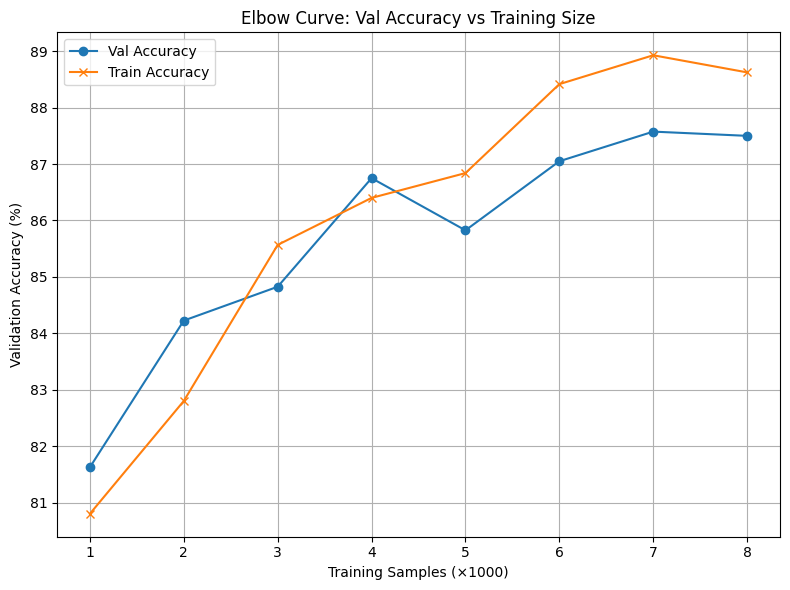

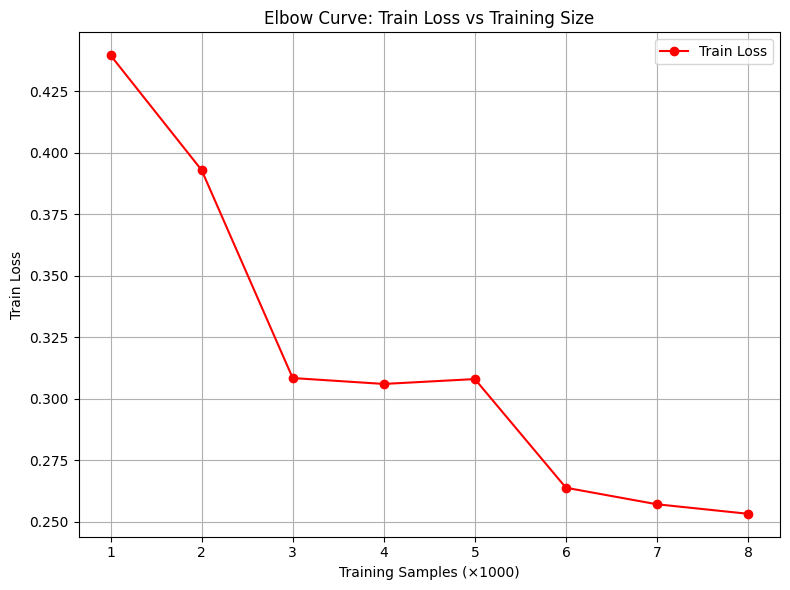

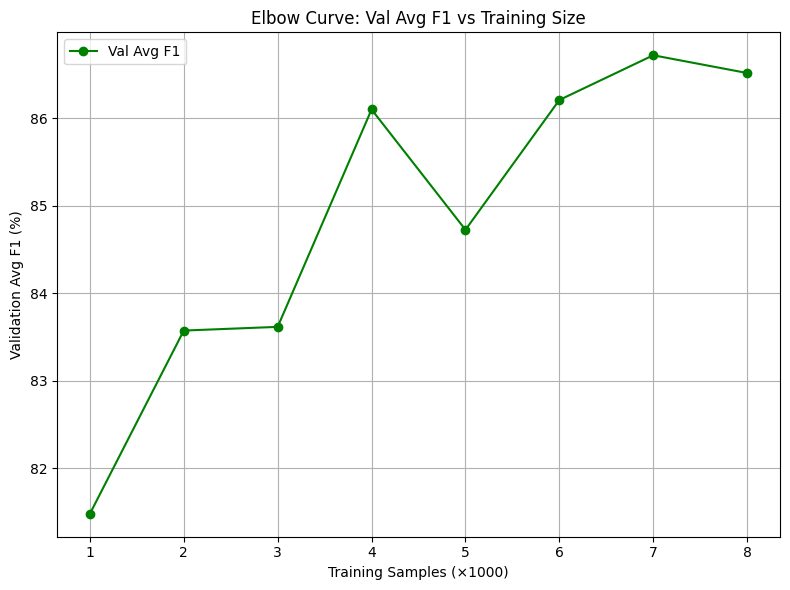

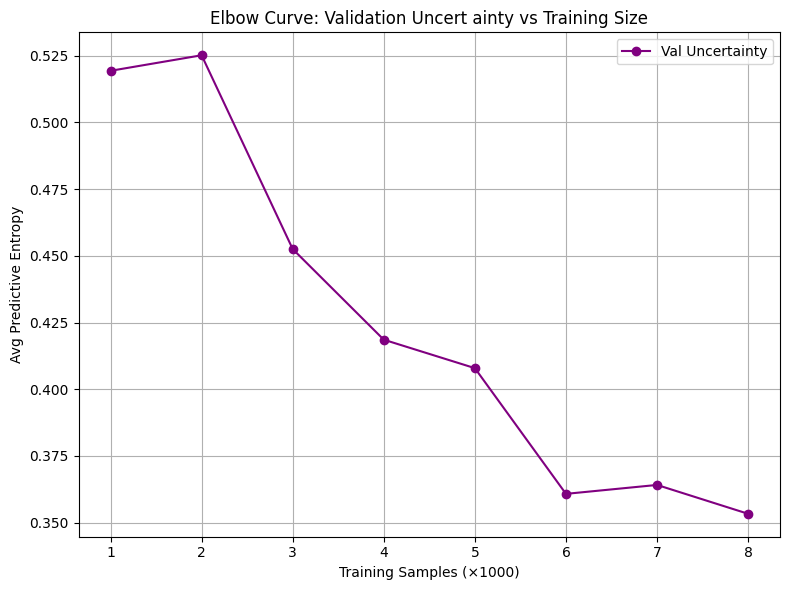

In [71]:
def plot_elbow_curve(elbow_history):
    x_vals = [x / 1000 for x in elbow_history["subset_size"]]

    # Accuracy
    plt.figure(figsize=(8, 6))
    y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
    plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
    plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Elbow Curve: Val Accuracy vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Train Loss
    plt.figure(figsize=(8, 6))
    y_vals = elbow_history["train_loss"]  # raw loss
    plt.plot(x_vals, y_vals, marker='o', color='red', label='Train Loss')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Train Loss")
    plt.title("Elbow Curve: Train Loss vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # F1 Score
    plt.figure(figsize=(8, 6))
    y_vals = [f1 * 100 for f1 in elbow_history["val_avg_f1"]]
    plt.plot(x_vals, y_vals, marker='o', color='green', label='Val Avg F1')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Validation Avg F1 (%)")
    plt.title("Elbow Curve: Val Avg F1 vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Entropy plot
    plt.figure(figsize=(8, 6))
    y_vals = elbow_history["val_uncertainty"]
    plt.plot(x_vals, y_vals, marker='o', color='purple', label='Val Uncertainty')
    plt.xlabel("Training Samples (×1000)")
    plt.ylabel("Avg Predictive Entropy")
    plt.title("Elbow Curve: Validation Uncert ainty vs Training Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



plot_elbow_curve(elbow_history)

<hr>

## Saving Result to Excel

In [72]:
def save_elbow_results_to_excel(filename, parameters_dict, elbow_history):
    # Convert parameters dict to string
    parameters_str = ", ".join([f"{k} = {v}" for k, v in parameters_dict.items()])

    # Load or create workbook
    if os.path.exists(filename):
        wb = load_workbook(filename)
        ws = wb.active
    else:
        wb = Workbook()
        ws = wb.active

        # Header row with bold font
        headers = ["Experiments", "Parameters", "Results"]
        bold_font = Font(bold=True)
        ws.append(headers)

        for col_num in range(1, len(headers) + 1):
            ws.cell(row=1, column=col_num).font = bold_font

    # For each subset size, append a row
    for i in range(len(elbow_history["subset_size"])):
        subset = elbow_history["subset_size"][i]
        train_acc = elbow_history["train_accuracy"][i] * 100
        train_loss = elbow_history["train_loss"][i]
        val_acc = elbow_history["val_accuracy"][i] * 100
        val_f1 = elbow_history["val_avg_f1"][i]

        experiment_name = f"Labeled Samples: {subset}"
        results_str = (
            f"TrainAcc = {train_acc:.2f}%, "
            f"TrainLoss = {train_loss:.4f}, "
            f"ValAcc = {val_acc:.2f}%, "
            f"Avg F1 = {val_f1:.4f}"
        )

        ws.append([experiment_name, parameters_str, results_str])

    wb.save(filename)
    print(f"Results saved to {filename}")

save_elbow_results_to_excel(
    filename="Results.xlsx",
    parameters_dict=parameters,
    elbow_history=elbow_history
)

Results saved to Results.xlsx


## AL Pipeline Loop

In [ ]:
# num_rounds = 10
# epochs = 50
# query_size = 100 
# sim = 20

# for name, query_func in sampling_strategies.items():
#     print(f"\n======================")
#     print(f" Running strategy: {name.upper()} ")
#     print(f"======================")    

#     labeled_pool = strategy_pools[name]["labeled"]
#     unlabeled_pool = strategy_pools[name]["unlabeled"]
#     print('Length of Labeled Pool:', len(labeled_pool))
#     print('Length of Unlabeled Pool:', len(unlabeled_pool))

#     history = strategy_histories[name]

#     for round_num in range(1, num_rounds + 1):
#         print(f"\n--- Round {round_num} [{name}] ---")

#         # Cold start: Re-initialize model at every round
#         backbone_copy = cnn().to(device)
#         fc_copy = FC(1024).to(device)
#         backbone_copy.load_state_dict(backbone_state)
#         fc_copy.load_state_dict(fc_state)
        
#         # 1. Query k samples
#         queried_indices = query_func(
#             X=X_train,
#             model_backbone=backbone_copy,
#             model_fc=fc_copy,
#             k=query_size,
#             device=device,
#             unlabeled_pool=unlabeled_pool
#         ) if name != "random" else query_func(query_size, unlabeled_pool)
    
#         # 2. Update pools
#         new_indices = set(queried_indices) - labeled_pool  # avoid duplication
#         labeled_pool.update(new_indices)
#         unlabeled_pool.difference_update(new_indices)
#         print('Length of Labeled Pool:', len(labeled_pool))
#         print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
#         # 3. Build train loader
#         train_dataset = SimpleDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
#         train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
#         # 4. Train + Evaluate
#         train(backbone_copy, fc_copy, train_loader, device, epochs=epochs)
#         f1s, acc, avg_f1 = eval_perf(val_dataloader, backbone_copy, fc_copy, device)
        
#         print("Per-class F1 scores:", f1s)
#         print(f"Overall Accuracy: {acc * 100:.2f}%")
#         print(f"Average F1 Score: {avg_f1:.4f}")
    
#         # 5. Update history
#         history["rounds"].append(round_num)
#         history["num_labeled"].append(len(labeled_pool))
#         history["accuracy"].append(acc)
#         history["avg_f1"].append(avg_f1)
#         history["f1s"].append(f1s.tolist())

In [ ]:
# # Accuracy Plot: Train vs Val
# fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

# for i, (name, history) in enumerate(strategy_histories.items()):
#     val_accs = [a * 100 for a in history["val_accuracy"]]
#     train_accs = [acc_list[-1] * 100 for acc_list in history["train_accuracy"]]  # last epoch of each round

#     axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
#     axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

#     axs[i].set_title(f"{name.capitalize()} Sampling")
#     axs[i].set_xlabel("Labeled Samples")
#     axs[i].set_ylabel("Accuracy (%)")
#     axs[i].legend()
#     axs[i].grid(True)

# plt.tight_layout()
# plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
# plt.show()


# # Average F1 Score Plot
# fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
# for i, (name, history) in enumerate(strategy_histories.items()):
#     axs[i].plot(history["num_labeled"], [a * 100 for a in history["val_avg_f1"]], marker="x", color='green')
#     axs[i].set_title(f"{name.capitalize()} Sampling")
#     axs[i].set_xlabel("Labeled Samples")
#     axs[i].set_ylabel("F1 Score (%)")
#     axs[i].grid(True)

# plt.tight_layout()
# plt.suptitle("Active Learning Strategy Comparison (F1 Score)", fontsize=16, y=1.05)
# plt.show()